In [124]:
from pathlib import Path
import sys
from collections import defaultdict
import torch
from torch.utils.tensorboard import SummaryWriter
from rl_envs.grid_world_env import GridWorldEnv
import numpy as np
from tools.helper import *
# from rl_envs.episodic_grid_world_env import EpisodicGridWorldEnv
# from rl_envs.grid_world_env import GridWorldEnv
from ReplayMemory import *
# from agents.DQN import DeepQLearningAgent
from agents.DQN_exact_book import DeepQLearningAgent
from torch.utils import data
%load_ext autoreload 
# %aimport rl_envs.grid_world_env

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [125]:
def print_actions(agent, env, get_optimal=False):
    with torch.no_grad():
        # action_mapping = [" ↓ "," ↑ "," → "," ← "," ↺ "]
        for i in range(env.height):
            print("[", end=" ")
            for j in range(env.width):
                state = (i, j)
                # state = torch.tensor((i,j), dtype=torch.float).unsqueeze(0)
                action = agent.get_action(state)
                print(env.action_mappings[action], end=" ")
            print("]")


# def state_normalize(state, height, width):
#     # normalize each to [0,1]
#     return (state[0]/(height-1),state[1]/(width-1))


BATCHSIZE = 100
LEARN_RATE = 0.0015  # change to 0.001
TRUE_RANDOM_STATE_VALUE = [
    [-3.8, -3.8, -3.6, -3.1, -3.2],
    [-3.8, -3.8, -3.8, -3.1, -2.9],
    [-3.6, -3.9, -3.4, -3.2, -2.9],
    [-3.9, -3.6, -3.4, -2.9, -3.2],
    [-4.5, -4.2, -3.4, -3.4, -3.5],
]
DISCOUNTED_FACTOR = 0.9
EPISODE_LEN = 5000


def calculate_state_value_error(env: GridWorldEnv, agent):
    # offline policy have 2 policies, I am using the behavior(random) policy for calculating
    with torch.no_grad():
        state_value_error = 0
        V = {}
        for i in range(env.height):
            for j in range(env.width):
                state = torch.tensor(
                    agent.state_normalize((i, j), env.height, env.width),
                    dtype=torch.float,
                ).unsqueeze(0)
                state_value = 0
                for action_ind in range(agent.action_space):
                    action = torch.tensor(
                        action_ind / (agent.action_space - 1), dtype=torch.float
                    ).view(-1, 1)
                    sa_pair = torch.cat([state, action], dim=1)
                    q_value = agent.policy_net(sa_pair)
                    state_value += q_value.item() * (1.0 / env.possible_actions)
                state_value_error += abs(state_value - TRUE_RANDOM_STATE_VALUE[i][j])
                V[(i, j)] = state_value
    return state_value_error, V

In [126]:
env = GridWorldEnv(
    5,
    5,
    forbidden_grids=[(1, 1), (1, 2), (2, 2), (3, 1), (3, 3), (4, 1)],
    target_grids=[(3, 2)],
    forbidden_reward=-1,
    hit_wall_reward=-1,
    target_reward=1,
)
agent = DeepQLearningAgent(
    input_dim=3,
    output_dim=1,
    action_space=env.possible_actions,
    lr=LEARN_RATE,
    discounted_factor=DISCOUNTED_FACTOR,
)
writer = SummaryWriter()

In [127]:
"""
generate samples to replay buffer
"""


# replay_buffer = ReplayMemory(2000)

# for _ in range(10):
#     state = env.reset()
#     for _ in range(200):
#         action = random.randint(0,4)
#         next_state, reward = env.step(state, action)
#         action = float(action)  / env.possible_actions # action also normalzie into [0,1]
#         replay_buffer.push(torch.tensor(agent.state_normalize(state, env.height, env.width), dtype=torch.float), torch.tensor(action, dtype=torch.float).unsqueeze(0), torch.tensor(reward, dtype=torch.float).unsqueeze(0), torch.tensor(agent.state_normalize(state, env.height, env.width), dtype=torch.float))
#         state = next_state


def obtain_episode(env: GridWorldEnv, start_state, length):
    f"""

    :param policy: 由指定策略产生episode
    :param start_state: 起始state
    :param start_action: 起始action
    :param length: episode 长度
    :return: 一个 state,action,reward,next_state,next_action 序列
    """
    episode = []
    next_state = start_state
    while length > 0:
        length -= 1
        state = next_state
        action = random.randint(0, 4)
        next_state, reward = env.step(state, action)
        episode.append(
            {
                "state": state,
                "action": action,
                "reward": reward,
                "next_state": next_state,
            }
        )
    return episode


def get_data_iter(episode, batch_size=64, is_train=True):
    """构造一个PyTorch数据迭代器"""
    reward = []
    state_action = []
    next_state = []
    for i in range(len(episode)):
        reward.append(episode[i]["reward"])
        action = episode[i]["action"]
        y, x = episode[i]["state"]
        state_action.append((y, x, action))
        next_state.append(episode[i]["next_state"])
    reward = torch.tensor(reward, dtype=torch.float).reshape(-1, 1)
    state_action = torch.tensor(state_action, dtype=torch.float)
    next_state = torch.tensor(next_state, dtype=torch.float)
    data_arrays = (state_action, reward, next_state)
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train, drop_last=False)

In [128]:
episode = obtain_episode(env, env.reset(), length=EPISODE_LEN)
date_iter = get_data_iter(episode, BATCHSIZE)

In [129]:
"""
perform DQN
"""
C = 10  # 0-50 感觉都差不多, 可能 15 更好 (但是或许是太小了, 反而 100-500 的模式或许才是对的) 1000>500?
# for C in [5]:
# for C in [1,2,3,5,8,13,21,34,50,80,100,200,300,500]:
# log_name = 'LR_{}_C_{}'.format(LEARN_RATE, C)
# writer = SummaryWriter(log_dir = 'runs/'+log_name)
epochs = 600

iter_counter = 0
for epoch in range(epochs):
    # for _ in range(50):
    for state_action, reward, next_state in date_iter:
        # transitions = replay_buffer.sample(BATCHSIZE)
        # batch = Transition(*zip(*transitions))
        # state = torch.stack(batch.state)
        # next_state = torch.stack(batch.next_state)
        # reward = torch.cat(batch.reward)
        # action_indices = torch.cat(batch.action)

        loss, q_value, target_value = agent.update_Q_network(
            state_action, reward, next_state
        )
        # copy target network every C=5 iteration
        # state_value_estimated = output.sum(dim=1) / env.possible_actions
        with torch.no_grad():
            writer.add_scalar(
                "TD error", (abs(q_value - target_value)).sum(), iter_counter
            )
            writer.add_scalar("Loss", loss.sum(), iter_counter)
            writer.add_scalar(
                "State value error",
                calculate_state_value_error(env, agent)[0],
                iter_counter,
            )
            iter_counter += 1
        if iter_counter % C == 0:
            # agent.target_net.load_state_dict(agent.policy_net.state_dict())
            agent.sync_target_network()
    if epoch % 100 == 0:
        print_actions(agent, env, True)
        print(iter_counter)

writer.flush()
writer.close()
print_actions(agent, env, True)
print()

[  →   ←   ←   ↺   ↺  ]
[  ↑   →   ↓   ←   ↺  ]
[  ↑   →   ↓   ↓   ↺  ]
[  ↑   →   ↓   ←   ↺  ]
[  ↑   ↑   →   ←   ↺  ]
50
[  ↓   →   ↓   ↓   ←  ]
[  ↓   ↓   ↓   ↓   ↓  ]
[  ↓   →   ↓   ←   ←  ]
[  →   →   ↺   ←   ←  ]
[  ↑   →   ↑   ←   ←  ]
5050
[  ↓   ↓   ↓   ↓   ↓  ]
[  ↓   ↓   ↓   ↓   ↓  ]
[  →   →   ↓   ←   ←  ]
[  →   →   ↺   ←   ←  ]
[  →   →   ↑   ←   ←  ]
10050
[  ↓   →   ↓   ↓   ←  ]
[  ↓   ↓   ↓   ↓   ↓  ]
[  →   →   ↓   ↓   ←  ]
[  →   →   ↺   ←   ←  ]
[  →   →   ↑   ←   ←  ]
15050
[  ↓   ↓   ↓   ↓   ↓  ]
[  ↓   ↓   ↓   ↓   ←  ]
[  →   →   ↓   ←   ←  ]
[  →   →   ↺   ←   ←  ]
[  →   →   ↑   ←   ←  ]
20050


In [ ]:
print(env)

print_actions(agent, env, True)

print()

# for i in range(env.height):
#     print("[", end=" ")
#     for j in range(env.width):
#         state = torch.tensor((i,j), dtype=torch.float).unsqueeze(0)
#         output = agent.policy_net(state)
#         state_value = output.sum()/env.possible_actions
#         state_value_error = (state_value - TRUE_RANDOM_STATE_VALUE[i][j])
#         print(state_value_error, end=" ")
#     print("]")

[ 0.000000 0.000000 0.000000 0.000000 0.000000 ]
[ 0.000000 -1.000000 -1.000000 0.000000 0.000000 ]
[ 0.000000 0.000000 -1.000000 0.000000 0.000000 ]
[ 0.000000 -1.000000 1.000000 -1.000000 0.000000 ]
[ 0.000000 -1.000000 0.000000 0.000000 0.000000 ]

[  ↓   ↓   ↓   ↓   ↓  ]
[  ↓   ↓   ↓   ↓   ↓  ]
[  ↓   ↓   ↓   ↓   ↓  ]
[  ↓   ↓   ↓   ↓   ↓  ]
[  ↓   ↓   ↓   ↓   ↓  ]



In [ ]:
Q = defaultdict(lambda: [0 for _ in range(agent.action_space)])
for i in range(env.height):
    for j in range(env.width):
        state = torch.tensor(
            agent.state_normalize((i, j), env.height, env.width), dtype=torch.float
        ).unsqueeze(0)
        for action_ind in range(agent.action_space):
            action = torch.tensor(
                action_ind / (agent.action_space - 1), dtype=torch.float
            ).view(-1, 1)
            sa_pair = torch.cat([state, action], dim=1)
            q_value = agent.policy_net(sa_pair)
            Q[(i, j)][action_ind] = q_value.item()
print_by_dict(env, Q)

[ [93.36235046386719, 93.73141479492188, 94.12934875488281, 94.51182556152344, 94.36990356445312] [93.00251770019531, 93.37684631347656, 93.71835327148438, 94.14588165283203, 94.91741180419922] [92.98573303222656, 93.25968170166016, 93.53964233398438, 93.86823272705078, 94.7834243774414] [93.03297424316406, 93.34012603759766, 93.75523376464844, 94.28099060058594, 95.04800415039062] [93.35488891601562, 93.723388671875, 94.08026123046875, 94.60969543457031, 95.3089599609375] ]
[ [93.33053588867188, 93.66581726074219, 94.07859802246094, 94.47525024414062, 94.83718872070312] [93.30938720703125, 93.5748062133789, 93.88264465332031, 94.29220581054688, 95.06005859375] [93.29646301269531, 93.57040405273438, 94.02786254882812, 94.40621185302734, 95.23324584960938] [93.28353881835938, 93.57726287841797, 94.1014633178711, 94.63011169433594, 95.4456787109375] [93.32843017578125, 93.78675842285156, 94.46665954589844, 95.02265930175781, 95.65316772460938] ]
[ [93.61885070800781, 94.021728515625, 94.

In [ ]:
state_error_sum, V = calculate_state_value_error(env, agent)
print(state_error_sum)
print()
print_by_dict(env, V)

2454.2868911743167

[ 94.02 93.83 93.69 93.89 94.22 ]
[ 94.08 94.02 94.11 94.21 94.45 ]
[ 94.37 94.41 94.57 94.66 94.78 ]
[ 94.80 94.97 95.06 95.20 95.23 ]
[ 95.27 95.57 95.67 95.69 95.63 ]


In [ ]:
V = {}
for state in Q.keys():
    V[state] = max(Q[state])
print_by_dict(env, V)

[ 94.51 94.92 94.78 95.05 95.31 ]
[ 94.84 95.06 95.23 95.45 95.65 ]
[ 95.12 95.19 95.58 95.78 95.94 ]
[ 95.43 95.71 95.86 96.12 96.14 ]
[ 95.77 96.17 96.58 96.44 96.29 ]


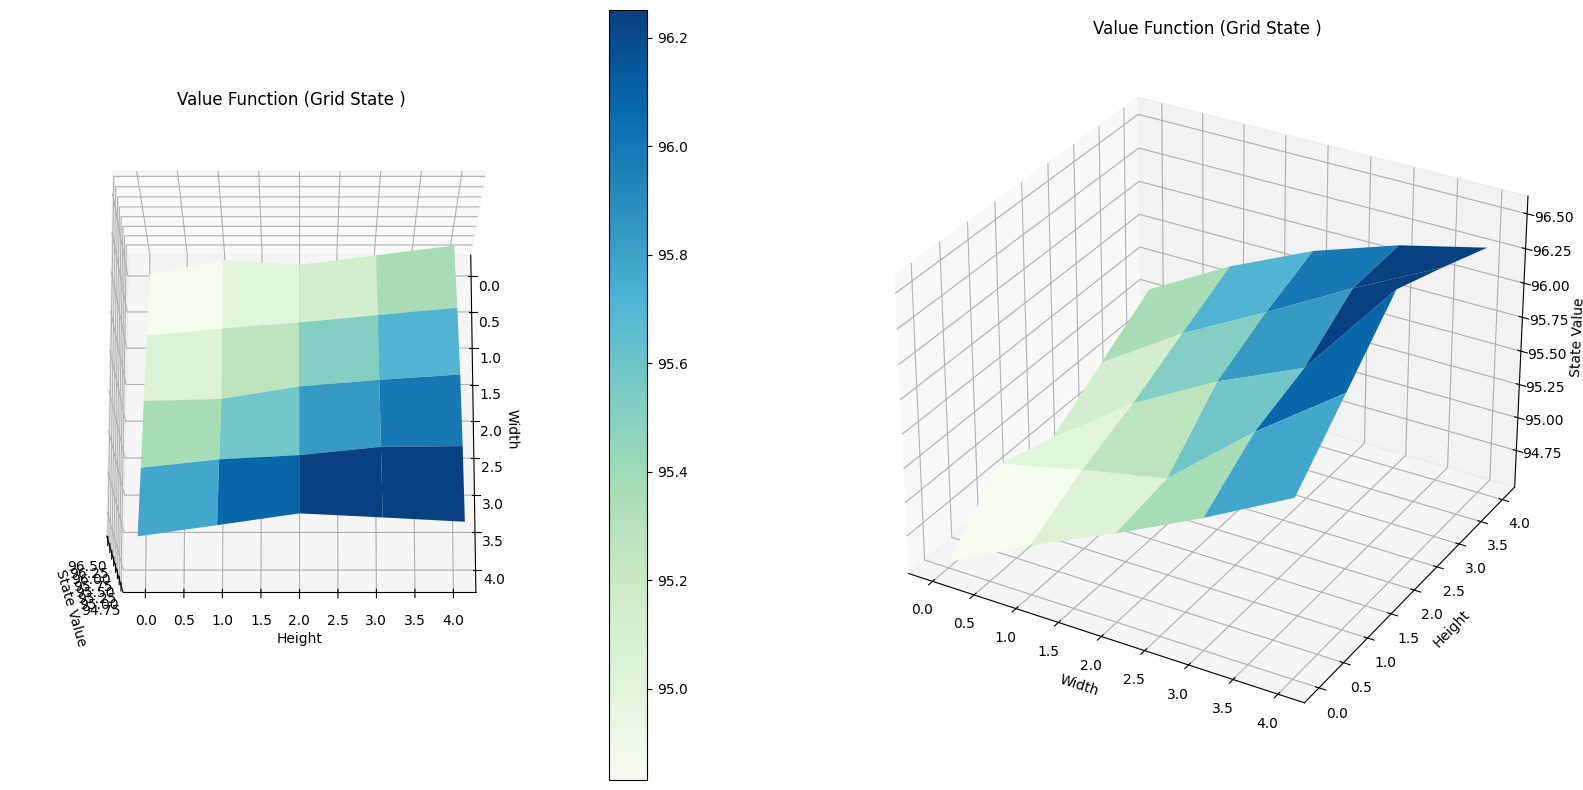

In [ ]:
plot_value_function(V)